# 目标检测：口罩佩戴检测  

<br>
<hr>

## 1.实验介绍

### 1.1 实验背景  

今年一场席卷全球的新型冠状病毒给人们带来了沉重的生命财产的损失。  
有效防御这种传染病毒的方法就是积极佩戴口罩。  
我国对此也采取了严肃的措施，在公共场合要求人们必须佩戴口罩。  
在本次实验中，我们要建立一个目标检测的模型，可以识别图中的人是否佩戴了口罩。

### 1.2 实验要求

1）建立深度学习模型，检测出图中的人是否佩戴了口罩，并将其尽可能调整到最佳状态。  
2）学习经典的模型 MTCNN 和 MobileNet 的结构。  
3）学习训练时的方法。  
<br>

### 1.3 实验环境

可以使用基于 Python 的 OpenCV 、PIL 库进行图像相关处理，使用 Numpy 库进行相关数值运算，使用 Pytorch 等深度学习框架训练模型等。
<br>
<br>

### 1.4 注意事项  
+ Python 与 Python Package 的使用方式，可在右侧 `API文档` 中查阅。
+ 当右上角的『Python 3』长时间指示为运行中的时候，造成代码无法执行时，可以重新启动 Kernel 解决（左上角『Kernel』-『Restart Kernel』）。

### 1.5 参考资料
+ 论文 Joint Face Detection and Alignment using Multi-task Cascaded Convolutional Networks：https://kpzhang93.github.io/MTCNN_face_detection_alignment/
+ OpenCV：https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_tutorials.html
+ PIL：https://pillow.readthedocs.io/en/stable/
+ Numpy：https://www.numpy.org/
+ Scikit-learn： https://scikit-learn.org/
+ PyTorch：https://pytorch.org/

### 1.6 实验思路

针对目标检测的任务，可以分为两个部分：目标识别和位置检测。  
通常情况下，特征提取需要由特有的特征提取神经网络来完成，如 VGG、MobileNet、ResNet 等，这些特征提取网络往往被称为 Backbone 。而在 BackBone 后面接全连接层(FC)就可以执行分类任务。  
但 FC 对目标的位置识别乏力。经过算法的发展，当前主要以特定的功能网络来代替 FC 的作用，如 Mask-Rcnn、SSD、YOLO 等。  
我们选择充分使用已有的人脸检测的模型，再训练一个识别口罩的模型，从而提高训练的开支、增强模型的准确率。

**常规目标检测：**  

<img src="https://imgbed.momodel.cn/20200914162156.png" width=500px/>



**本次案例：**   


<img src="https://imgbed.momodel.cn/20200918102630.png" width=500px/>

<br>
<br>

## 2.数据集介绍

### 2.1 导入 Python 第三方库（包）

In [1]:
import warnings
# 忽视警告
warnings.filterwarnings('ignore')

import cv2
from PIL import Image
import numpy as np
import copy
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
from torch.utils.data import DataLoader

### 2.2 导入已经写好的 Python 文件

In [2]:
#from torch_py.Utils import plot_image
#from torch_py.MTCNN.detector import FaceDetector
#from torch_py.MobileNetV1 import MobileNetV1
#from torch_py.FaceRec import Recognition

In [3]:
def processing_data(data_path, height=112, width=112, batch_size=48,
                    test_split=0.1):
    """
    数据处理部分
    :param data_path: 数据路径
    :param height:高度
    :param width: 宽度
    :param batch_size: 每次读取图片的数量
    :param test_split: 测试集划分比例
    :return: 
    """
    transforms = T.Compose([
        T.Resize((height, width)),
        T.RandomHorizontalFlip(0.1),  # 进行随机水平翻转
        T.RandomVerticalFlip(0.1),  # 进行随机竖直翻转
        T.ToTensor(),  # 转化为张量
        T.Normalize([0], [1]),  # 归一化
    ])

    dataset = ImageFolder(data_path, transform=transforms)
    # 划分数据集
    train_size = int((1-test_split)*len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
    # 创建一个 DataLoader 对象
    train_data_loader = DataLoader(train_dataset, batch_size=batch_size,shuffle=True)
    valid_data_loader = DataLoader(test_dataset, batch_size=batch_size,shuffle=True)

    return train_data_loader, valid_data_loader

## 4. 口罩识别



### 4.1 加载预训练模型 MobileNet

In [4]:
# 加载 MobileNet 的预训练模型权
from model import ArcfaceNet
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
train_data_loader, valid_data_loader = processing_data(data_path='./data/image', height=112, width=112, batch_size=468)
epochs = 500
model = ArcfaceNet(classes=2).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3,weight_decay=5e-4)  # 优化器
print('加载完成...')

加载完成...


### **4.2 手动调整学习率**(可调参）

学习率的手动设置可以使模型训练更加高效。  
这里我们设置当模型在两轮迭代后，准确率没有上升，就调整学习率。

In [5]:
# 学习率下降的方式，acc三次不下降就下降学习率继续训练，衰减学习率
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                 'max', 
                                                 factor=0.5,
                                                 patience=2)
# 损失函数
criterion = nn.CrossEntropyLoss()  

### 4.3 训练模型

In [6]:
best_loss = 1e9
best_model_weights = copy.deepcopy(model.state_dict())
loss_list = []  # 存储损失函数值
for epoch in range(epochs):
    model.train()
    #model.Arcnet.requires_grad = False
    for batch_idx, (x, y) in tqdm(enumerate(train_data_loader, 1)):
        x = x.to(device)
        y = y.to(device)
        pred_y = model(x)

        # print(pred_y.shape)
        # print(y.shape)

        loss = criterion(pred_y, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if loss < best_loss:
            best_model_weights = copy.deepcopy(model.state_dict())
            best_loss = loss
            
        loss_list.append(loss)

    print('step:' + str(epoch + 1) + '/' + str(epochs) + ' || Total Loss: %.4f' % (loss))
torch.save(model.state_dict(), 'temp.pth')
print('Finish Training.')


0it [00:00, ?it/s]

step:1/500 || Total Loss: 0.6353


0it [00:00, ?it/s]

step:2/500 || Total Loss: 0.5571


0it [00:00, ?it/s]

step:3/500 || Total Loss: 0.5765


0it [00:00, ?it/s]

step:4/500 || Total Loss: 0.5478


0it [00:00, ?it/s]

step:5/500 || Total Loss: 0.5097


0it [00:00, ?it/s]

step:6/500 || Total Loss: 0.4942


0it [00:00, ?it/s]

step:7/500 || Total Loss: 0.4747


0it [00:00, ?it/s]

step:8/500 || Total Loss: 0.4664


0it [00:00, ?it/s]

step:9/500 || Total Loss: 0.4472


0it [00:00, ?it/s]

step:10/500 || Total Loss: 0.4354


0it [00:00, ?it/s]

step:11/500 || Total Loss: 0.4295


0it [00:00, ?it/s]

step:12/500 || Total Loss: 0.4144


0it [00:00, ?it/s]

step:13/500 || Total Loss: 0.4069


0it [00:00, ?it/s]

step:14/500 || Total Loss: 0.4140


0it [00:00, ?it/s]

step:15/500 || Total Loss: 0.3951


0it [00:00, ?it/s]

step:16/500 || Total Loss: 0.3994


0it [00:00, ?it/s]

step:17/500 || Total Loss: 0.3842


0it [00:00, ?it/s]

step:18/500 || Total Loss: 0.3914


0it [00:00, ?it/s]

step:19/500 || Total Loss: 0.3832


0it [00:00, ?it/s]

step:20/500 || Total Loss: 0.3761


0it [00:00, ?it/s]

step:21/500 || Total Loss: 0.3702


0it [00:00, ?it/s]

step:22/500 || Total Loss: 0.3830


0it [00:00, ?it/s]

step:23/500 || Total Loss: 0.3665


0it [00:00, ?it/s]

step:24/500 || Total Loss: 0.3666


0it [00:00, ?it/s]

step:25/500 || Total Loss: 0.3613


0it [00:00, ?it/s]

step:26/500 || Total Loss: 0.3687


0it [00:00, ?it/s]

step:27/500 || Total Loss: 0.3714


0it [00:00, ?it/s]

step:28/500 || Total Loss: 0.3978


0it [00:00, ?it/s]

step:29/500 || Total Loss: 0.3702


0it [00:00, ?it/s]

step:30/500 || Total Loss: 0.3811


0it [00:00, ?it/s]

step:31/500 || Total Loss: 0.3772


0it [00:00, ?it/s]

step:32/500 || Total Loss: 0.3592


0it [00:00, ?it/s]

step:33/500 || Total Loss: 0.3517


0it [00:00, ?it/s]

step:34/500 || Total Loss: 0.3533


0it [00:00, ?it/s]

step:35/500 || Total Loss: 0.3467


0it [00:00, ?it/s]

step:36/500 || Total Loss: 0.3482


0it [00:00, ?it/s]

step:37/500 || Total Loss: 0.3700


0it [00:00, ?it/s]

step:38/500 || Total Loss: 0.3446


0it [00:00, ?it/s]

step:39/500 || Total Loss: 0.3626


0it [00:00, ?it/s]

step:40/500 || Total Loss: 0.3562


0it [00:00, ?it/s]

step:41/500 || Total Loss: 0.3643


0it [00:00, ?it/s]

step:42/500 || Total Loss: 0.3594


0it [00:00, ?it/s]

step:43/500 || Total Loss: 0.3475


0it [00:00, ?it/s]

step:44/500 || Total Loss: 0.3409


0it [00:00, ?it/s]

step:45/500 || Total Loss: 0.3451


0it [00:00, ?it/s]

step:46/500 || Total Loss: 0.3468


0it [00:00, ?it/s]

step:47/500 || Total Loss: 0.3442


0it [00:00, ?it/s]

step:48/500 || Total Loss: 0.3487


0it [00:00, ?it/s]

step:49/500 || Total Loss: 0.3610


0it [00:00, ?it/s]

step:50/500 || Total Loss: 0.3435


0it [00:00, ?it/s]

step:51/500 || Total Loss: 0.3676


0it [00:00, ?it/s]

step:52/500 || Total Loss: 0.3477


0it [00:00, ?it/s]

step:53/500 || Total Loss: 0.3374


0it [00:00, ?it/s]

step:54/500 || Total Loss: 0.3418


0it [00:00, ?it/s]

step:55/500 || Total Loss: 0.3592


0it [00:00, ?it/s]

step:56/500 || Total Loss: 0.3452


0it [00:00, ?it/s]

step:57/500 || Total Loss: 0.3407


0it [00:00, ?it/s]

step:58/500 || Total Loss: 0.3510


0it [00:00, ?it/s]

step:59/500 || Total Loss: 0.3284


0it [00:00, ?it/s]

step:60/500 || Total Loss: 0.3337


0it [00:00, ?it/s]

step:61/500 || Total Loss: 0.3337


0it [00:00, ?it/s]

step:62/500 || Total Loss: 0.3373


0it [00:00, ?it/s]

step:63/500 || Total Loss: 0.3353


0it [00:00, ?it/s]

step:64/500 || Total Loss: 0.3274


0it [00:00, ?it/s]

step:65/500 || Total Loss: 0.3378


0it [00:00, ?it/s]

step:66/500 || Total Loss: 0.3453


0it [00:00, ?it/s]

step:67/500 || Total Loss: 0.3307


0it [00:00, ?it/s]

step:68/500 || Total Loss: 0.3744


0it [00:00, ?it/s]

step:69/500 || Total Loss: 0.3537


0it [00:00, ?it/s]

step:70/500 || Total Loss: 0.3540


0it [00:00, ?it/s]

step:71/500 || Total Loss: 0.3410


0it [00:00, ?it/s]

step:72/500 || Total Loss: 0.3414


0it [00:00, ?it/s]

step:73/500 || Total Loss: 0.3359


0it [00:00, ?it/s]

step:74/500 || Total Loss: 0.3371


0it [00:00, ?it/s]

step:75/500 || Total Loss: 0.3299


0it [00:00, ?it/s]

step:76/500 || Total Loss: 0.3471


0it [00:00, ?it/s]

step:77/500 || Total Loss: 0.3352


0it [00:00, ?it/s]

step:78/500 || Total Loss: 0.3351


0it [00:00, ?it/s]

step:79/500 || Total Loss: 0.3236


0it [00:00, ?it/s]

step:80/500 || Total Loss: 0.3232


0it [00:00, ?it/s]

step:81/500 || Total Loss: 0.3282


0it [00:00, ?it/s]

step:82/500 || Total Loss: 0.3360


0it [00:00, ?it/s]

step:83/500 || Total Loss: 0.3344


0it [00:00, ?it/s]

step:84/500 || Total Loss: 0.3396


0it [00:00, ?it/s]

step:85/500 || Total Loss: 0.3397


0it [00:00, ?it/s]

step:86/500 || Total Loss: 0.3392


0it [00:00, ?it/s]

step:87/500 || Total Loss: 0.3223


0it [00:00, ?it/s]

step:88/500 || Total Loss: 0.3225


0it [00:00, ?it/s]

step:89/500 || Total Loss: 0.3223


0it [00:00, ?it/s]

step:90/500 || Total Loss: 0.3276


0it [00:00, ?it/s]

step:91/500 || Total Loss: 0.3338


0it [00:00, ?it/s]

step:92/500 || Total Loss: 0.3400


0it [00:00, ?it/s]

step:93/500 || Total Loss: 0.3389


0it [00:00, ?it/s]

step:94/500 || Total Loss: 0.3212


0it [00:00, ?it/s]

step:95/500 || Total Loss: 0.3374


0it [00:00, ?it/s]

step:96/500 || Total Loss: 0.3294


0it [00:00, ?it/s]

step:97/500 || Total Loss: 0.3391


0it [00:00, ?it/s]

step:98/500 || Total Loss: 0.3281


0it [00:00, ?it/s]

step:99/500 || Total Loss: 0.3458


0it [00:00, ?it/s]

step:100/500 || Total Loss: 0.3402


0it [00:00, ?it/s]

step:101/500 || Total Loss: 0.3309


0it [00:00, ?it/s]

step:102/500 || Total Loss: 0.3465


0it [00:00, ?it/s]

step:103/500 || Total Loss: 0.3410


0it [00:00, ?it/s]

step:104/500 || Total Loss: 0.3398


0it [00:00, ?it/s]

step:105/500 || Total Loss: 0.3539


0it [00:00, ?it/s]

step:106/500 || Total Loss: 0.3323


0it [00:00, ?it/s]

step:107/500 || Total Loss: 0.3355


0it [00:00, ?it/s]

step:108/500 || Total Loss: 0.3421


0it [00:00, ?it/s]

step:109/500 || Total Loss: 0.3357


0it [00:00, ?it/s]

step:110/500 || Total Loss: 0.3270


0it [00:00, ?it/s]

step:111/500 || Total Loss: 0.3465


0it [00:00, ?it/s]

step:112/500 || Total Loss: 0.3339


0it [00:00, ?it/s]

step:113/500 || Total Loss: 0.3375


0it [00:00, ?it/s]

step:114/500 || Total Loss: 0.3316


0it [00:00, ?it/s]

step:115/500 || Total Loss: 0.3320


0it [00:00, ?it/s]

step:116/500 || Total Loss: 0.3367


0it [00:00, ?it/s]

step:117/500 || Total Loss: 0.3194


0it [00:00, ?it/s]

step:118/500 || Total Loss: 0.3367


0it [00:00, ?it/s]

step:119/500 || Total Loss: 0.3320


0it [00:00, ?it/s]

step:120/500 || Total Loss: 0.3206


0it [00:00, ?it/s]

step:121/500 || Total Loss: 0.3243


0it [00:00, ?it/s]

step:122/500 || Total Loss: 0.3252


0it [00:00, ?it/s]

step:123/500 || Total Loss: 0.3252


0it [00:00, ?it/s]

step:124/500 || Total Loss: 0.3195


0it [00:00, ?it/s]

step:125/500 || Total Loss: 0.3299


0it [00:00, ?it/s]

step:126/500 || Total Loss: 0.3266


0it [00:00, ?it/s]

step:127/500 || Total Loss: 0.3200


0it [00:00, ?it/s]

step:128/500 || Total Loss: 0.3200


0it [00:00, ?it/s]

step:129/500 || Total Loss: 0.3252


0it [00:00, ?it/s]

step:130/500 || Total Loss: 0.3325


0it [00:00, ?it/s]

step:131/500 || Total Loss: 0.3323


0it [00:00, ?it/s]

step:132/500 || Total Loss: 0.3241


0it [00:00, ?it/s]

step:133/500 || Total Loss: 0.3189


0it [00:00, ?it/s]

step:134/500 || Total Loss: 0.3300


0it [00:00, ?it/s]

step:135/500 || Total Loss: 0.3270


0it [00:00, ?it/s]

step:136/500 || Total Loss: 0.3595


0it [00:00, ?it/s]

step:137/500 || Total Loss: 0.3262


0it [00:00, ?it/s]

step:138/500 || Total Loss: 0.3240


0it [00:00, ?it/s]

step:139/500 || Total Loss: 0.3299


0it [00:00, ?it/s]

step:140/500 || Total Loss: 0.3292


0it [00:00, ?it/s]

step:141/500 || Total Loss: 0.3364


0it [00:00, ?it/s]

step:142/500 || Total Loss: 0.3307


0it [00:00, ?it/s]

step:143/500 || Total Loss: 0.3690


0it [00:00, ?it/s]

step:144/500 || Total Loss: 0.3310


0it [00:00, ?it/s]

step:145/500 || Total Loss: 0.3588


0it [00:00, ?it/s]

step:146/500 || Total Loss: 0.3429


0it [00:00, ?it/s]

step:147/500 || Total Loss: 0.3526


0it [00:00, ?it/s]

step:148/500 || Total Loss: 0.3527


0it [00:00, ?it/s]

step:149/500 || Total Loss: 0.3300


0it [00:00, ?it/s]

step:150/500 || Total Loss: 0.3408


0it [00:00, ?it/s]

step:151/500 || Total Loss: 0.3178


0it [00:00, ?it/s]

step:152/500 || Total Loss: 0.3235


0it [00:00, ?it/s]

step:153/500 || Total Loss: 0.3278


0it [00:00, ?it/s]

step:154/500 || Total Loss: 0.3239


0it [00:00, ?it/s]

step:155/500 || Total Loss: 0.3239


0it [00:00, ?it/s]

step:156/500 || Total Loss: 0.3381


0it [00:00, ?it/s]

step:157/500 || Total Loss: 0.3176


0it [00:00, ?it/s]

step:158/500 || Total Loss: 0.3348


0it [00:00, ?it/s]

step:159/500 || Total Loss: 0.3215


0it [00:00, ?it/s]

step:160/500 || Total Loss: 0.3237


0it [00:00, ?it/s]

step:161/500 || Total Loss: 0.3353


0it [00:00, ?it/s]

step:162/500 || Total Loss: 0.3233


0it [00:00, ?it/s]

step:163/500 || Total Loss: 0.3173


0it [00:00, ?it/s]

step:164/500 || Total Loss: 0.3173


0it [00:00, ?it/s]

step:165/500 || Total Loss: 0.3214


0it [00:00, ?it/s]

step:166/500 || Total Loss: 0.3219


0it [00:00, ?it/s]

step:167/500 || Total Loss: 0.3179


0it [00:00, ?it/s]

step:168/500 || Total Loss: 0.3233


0it [00:00, ?it/s]

step:169/500 || Total Loss: 0.3239


0it [00:00, ?it/s]

step:170/500 || Total Loss: 0.3183


0it [00:00, ?it/s]

step:171/500 || Total Loss: 0.3232


0it [00:00, ?it/s]

step:172/500 || Total Loss: 0.3263


0it [00:00, ?it/s]

step:173/500 || Total Loss: 0.3251


0it [00:00, ?it/s]

step:174/500 || Total Loss: 0.3229


0it [00:00, ?it/s]

step:175/500 || Total Loss: 0.3214


0it [00:00, ?it/s]

step:176/500 || Total Loss: 0.3207


0it [00:00, ?it/s]

step:177/500 || Total Loss: 0.3287


0it [00:00, ?it/s]

step:178/500 || Total Loss: 0.3286


0it [00:00, ?it/s]

step:179/500 || Total Loss: 0.3251


0it [00:00, ?it/s]

step:180/500 || Total Loss: 0.3342


0it [00:00, ?it/s]

step:181/500 || Total Loss: 0.3201


0it [00:00, ?it/s]

step:182/500 || Total Loss: 0.3435


0it [00:00, ?it/s]

step:183/500 || Total Loss: 0.3169


0it [00:00, ?it/s]

step:184/500 || Total Loss: 0.3169


0it [00:00, ?it/s]

step:185/500 || Total Loss: 0.3333


0it [00:00, ?it/s]

step:186/500 || Total Loss: 0.3334


0it [00:00, ?it/s]

step:187/500 || Total Loss: 0.3387


0it [00:00, ?it/s]

step:188/500 || Total Loss: 0.3348


0it [00:00, ?it/s]

step:189/500 || Total Loss: 0.3401


0it [00:00, ?it/s]

step:190/500 || Total Loss: 0.3226


0it [00:00, ?it/s]

step:191/500 || Total Loss: 0.3289


0it [00:00, ?it/s]

step:192/500 || Total Loss: 0.3225


0it [00:00, ?it/s]

step:193/500 || Total Loss: 0.3176


0it [00:00, ?it/s]

step:194/500 || Total Loss: 0.3291


0it [00:00, ?it/s]

step:195/500 || Total Loss: 0.3228


0it [00:00, ?it/s]

step:196/500 || Total Loss: 0.3169


0it [00:00, ?it/s]

step:197/500 || Total Loss: 0.3224


0it [00:00, ?it/s]

step:198/500 || Total Loss: 0.3339


0it [00:00, ?it/s]

step:199/500 || Total Loss: 0.3340


0it [00:00, ?it/s]

step:200/500 || Total Loss: 0.3284


0it [00:00, ?it/s]

step:201/500 || Total Loss: 0.3289


0it [00:00, ?it/s]

step:202/500 || Total Loss: 0.3455


0it [00:00, ?it/s]

step:203/500 || Total Loss: 0.3352


0it [00:00, ?it/s]

step:204/500 || Total Loss: 0.3406


0it [00:00, ?it/s]

step:205/500 || Total Loss: 0.3234


0it [00:00, ?it/s]

step:206/500 || Total Loss: 0.3188


0it [00:00, ?it/s]

step:207/500 || Total Loss: 0.3258


0it [00:00, ?it/s]

step:208/500 || Total Loss: 0.3303


0it [00:00, ?it/s]

step:209/500 || Total Loss: 0.3457


0it [00:00, ?it/s]

step:210/500 || Total Loss: 0.3449


0it [00:00, ?it/s]

step:211/500 || Total Loss: 0.3216


0it [00:00, ?it/s]

step:212/500 || Total Loss: 0.3281


0it [00:00, ?it/s]

step:213/500 || Total Loss: 0.3347


0it [00:00, ?it/s]

step:214/500 || Total Loss: 0.3166


0it [00:00, ?it/s]

step:215/500 || Total Loss: 0.3164


0it [00:00, ?it/s]

step:216/500 || Total Loss: 0.3223


0it [00:00, ?it/s]

step:217/500 || Total Loss: 0.3182


0it [00:00, ?it/s]

step:218/500 || Total Loss: 0.3262


0it [00:00, ?it/s]

step:219/500 || Total Loss: 0.3280


0it [00:00, ?it/s]

step:220/500 || Total Loss: 0.3260


0it [00:00, ?it/s]

step:221/500 || Total Loss: 0.3273


0it [00:00, ?it/s]

step:222/500 || Total Loss: 0.3183


0it [00:00, ?it/s]

step:223/500 || Total Loss: 0.3346


0it [00:00, ?it/s]

step:224/500 || Total Loss: 0.3280


0it [00:00, ?it/s]

step:225/500 || Total Loss: 0.3245


0it [00:00, ?it/s]

step:226/500 || Total Loss: 0.3690


0it [00:00, ?it/s]

step:227/500 || Total Loss: 0.3365


0it [00:00, ?it/s]

step:228/500 || Total Loss: 0.3167


0it [00:00, ?it/s]

step:229/500 || Total Loss: 0.3374


0it [00:00, ?it/s]

step:230/500 || Total Loss: 0.3384


0it [00:00, ?it/s]

step:231/500 || Total Loss: 0.3286


0it [00:00, ?it/s]

step:232/500 || Total Loss: 0.3397


0it [00:00, ?it/s]

step:233/500 || Total Loss: 0.3285


0it [00:00, ?it/s]

step:234/500 || Total Loss: 0.3346


0it [00:00, ?it/s]

step:235/500 || Total Loss: 0.3220


0it [00:00, ?it/s]

step:236/500 || Total Loss: 0.3219


0it [00:00, ?it/s]

step:237/500 || Total Loss: 0.3304


0it [00:00, ?it/s]

step:238/500 || Total Loss: 0.3161


0it [00:00, ?it/s]

step:239/500 || Total Loss: 0.3324


0it [00:00, ?it/s]

step:240/500 || Total Loss: 0.3219


0it [00:00, ?it/s]

step:241/500 || Total Loss: 0.3192


0it [00:00, ?it/s]

step:242/500 || Total Loss: 0.3393


0it [00:00, ?it/s]

step:243/500 || Total Loss: 0.3253


0it [00:00, ?it/s]

step:244/500 || Total Loss: 0.3210


0it [00:00, ?it/s]

step:245/500 || Total Loss: 0.3276


0it [00:00, ?it/s]

step:246/500 || Total Loss: 0.3161


0it [00:00, ?it/s]

step:247/500 || Total Loss: 0.3177


0it [00:00, ?it/s]

step:248/500 || Total Loss: 0.3344


0it [00:00, ?it/s]

step:249/500 || Total Loss: 0.3335


0it [00:00, ?it/s]

step:250/500 || Total Loss: 0.3178


0it [00:00, ?it/s]

step:251/500 || Total Loss: 0.3282


0it [00:00, ?it/s]

step:252/500 || Total Loss: 0.3232


0it [00:00, ?it/s]

step:253/500 || Total Loss: 0.3263


0it [00:00, ?it/s]

step:254/500 || Total Loss: 0.3217


0it [00:00, ?it/s]

step:255/500 || Total Loss: 0.3159


0it [00:00, ?it/s]

step:256/500 || Total Loss: 0.3230


0it [00:00, ?it/s]

step:257/500 || Total Loss: 0.3206


0it [00:00, ?it/s]

step:258/500 || Total Loss: 0.3205


0it [00:00, ?it/s]

step:259/500 || Total Loss: 0.3159


0it [00:00, ?it/s]

step:260/500 || Total Loss: 0.3164


0it [00:00, ?it/s]

step:261/500 || Total Loss: 0.3219


0it [00:00, ?it/s]

step:262/500 || Total Loss: 0.3159


0it [00:00, ?it/s]

step:263/500 || Total Loss: 0.3269


0it [00:00, ?it/s]

step:264/500 || Total Loss: 0.3212


0it [00:00, ?it/s]

step:265/500 || Total Loss: 0.3274


0it [00:00, ?it/s]

step:266/500 || Total Loss: 0.3205


0it [00:00, ?it/s]

step:267/500 || Total Loss: 0.3157


0it [00:00, ?it/s]

step:268/500 || Total Loss: 0.3251


0it [00:00, ?it/s]

step:269/500 || Total Loss: 0.3161


0it [00:00, ?it/s]

step:270/500 || Total Loss: 0.3248


0it [00:00, ?it/s]

step:271/500 || Total Loss: 0.3241


0it [00:00, ?it/s]

step:272/500 || Total Loss: 0.3215


0it [00:00, ?it/s]

step:273/500 || Total Loss: 0.3312


0it [00:00, ?it/s]

step:274/500 || Total Loss: 0.3439


0it [00:00, ?it/s]

step:275/500 || Total Loss: 0.3312


0it [00:00, ?it/s]

step:276/500 || Total Loss: 0.3737


0it [00:00, ?it/s]

step:277/500 || Total Loss: 0.3681


0it [00:00, ?it/s]

step:278/500 || Total Loss: 0.3570


0it [00:00, ?it/s]

step:279/500 || Total Loss: 0.3711


0it [00:00, ?it/s]

step:280/500 || Total Loss: 0.3464


0it [00:00, ?it/s]

step:281/500 || Total Loss: 0.3481


0it [00:00, ?it/s]

step:282/500 || Total Loss: 0.3589


0it [00:00, ?it/s]

step:283/500 || Total Loss: 0.3677


0it [00:00, ?it/s]

step:284/500 || Total Loss: 0.3806


0it [00:00, ?it/s]

step:285/500 || Total Loss: 0.3509


0it [00:00, ?it/s]

step:286/500 || Total Loss: 0.3647


0it [00:00, ?it/s]

step:287/500 || Total Loss: 0.3446


0it [00:00, ?it/s]

step:288/500 || Total Loss: 0.3417


0it [00:00, ?it/s]

step:289/500 || Total Loss: 0.3525


0it [00:00, ?it/s]

step:290/500 || Total Loss: 0.3321


0it [00:00, ?it/s]

step:291/500 || Total Loss: 0.3343


0it [00:00, ?it/s]

step:292/500 || Total Loss: 0.3362


0it [00:00, ?it/s]

step:293/500 || Total Loss: 0.3296


0it [00:00, ?it/s]

step:294/500 || Total Loss: 0.3337


0it [00:00, ?it/s]

step:295/500 || Total Loss: 0.3287


0it [00:00, ?it/s]

step:296/500 || Total Loss: 0.3215


0it [00:00, ?it/s]

step:297/500 || Total Loss: 0.3160


0it [00:00, ?it/s]

step:298/500 || Total Loss: 0.3205


0it [00:00, ?it/s]

step:299/500 || Total Loss: 0.3225


0it [00:00, ?it/s]

step:300/500 || Total Loss: 0.3217


0it [00:00, ?it/s]

step:301/500 || Total Loss: 0.3208


0it [00:00, ?it/s]

step:302/500 || Total Loss: 0.3318


0it [00:00, ?it/s]

step:303/500 || Total Loss: 0.3226


0it [00:00, ?it/s]

step:304/500 || Total Loss: 0.3156


0it [00:00, ?it/s]

step:305/500 || Total Loss: 0.3156


0it [00:00, ?it/s]

step:306/500 || Total Loss: 0.3215


0it [00:00, ?it/s]

step:307/500 || Total Loss: 0.3218


0it [00:00, ?it/s]

step:308/500 || Total Loss: 0.3156


0it [00:00, ?it/s]

step:309/500 || Total Loss: 0.3331


0it [00:00, ?it/s]

step:310/500 || Total Loss: 0.3272


0it [00:00, ?it/s]

step:311/500 || Total Loss: 0.3271


0it [00:00, ?it/s]

step:312/500 || Total Loss: 0.3276


0it [00:00, ?it/s]

step:313/500 || Total Loss: 0.3154


0it [00:00, ?it/s]

step:314/500 || Total Loss: 0.3270


0it [00:00, ?it/s]

step:315/500 || Total Loss: 0.3226


0it [00:00, ?it/s]

step:316/500 || Total Loss: 0.3214


0it [00:00, ?it/s]

step:317/500 || Total Loss: 0.3207


0it [00:00, ?it/s]

step:318/500 || Total Loss: 0.3156


0it [00:00, ?it/s]

step:319/500 || Total Loss: 0.3224


0it [00:00, ?it/s]

step:320/500 || Total Loss: 0.3310


0it [00:00, ?it/s]

step:321/500 || Total Loss: 0.3390


0it [00:00, ?it/s]

step:322/500 || Total Loss: 0.3212


0it [00:00, ?it/s]

step:323/500 || Total Loss: 0.3156


0it [00:00, ?it/s]

step:324/500 || Total Loss: 0.3270


0it [00:00, ?it/s]

step:325/500 || Total Loss: 0.3214


0it [00:00, ?it/s]

step:326/500 || Total Loss: 0.3258


0it [00:00, ?it/s]

step:327/500 || Total Loss: 0.3212


0it [00:00, ?it/s]

step:328/500 || Total Loss: 0.3269


0it [00:00, ?it/s]

step:329/500 || Total Loss: 0.3268


0it [00:00, ?it/s]

step:330/500 || Total Loss: 0.3242


0it [00:00, ?it/s]

step:331/500 || Total Loss: 0.3202


0it [00:00, ?it/s]

step:332/500 || Total Loss: 0.3541


0it [00:00, ?it/s]

step:333/500 || Total Loss: 0.3275


0it [00:00, ?it/s]

step:334/500 || Total Loss: 0.3155


0it [00:00, ?it/s]

step:335/500 || Total Loss: 0.3210


0it [00:00, ?it/s]

step:336/500 || Total Loss: 0.3154


0it [00:00, ?it/s]

step:337/500 || Total Loss: 0.3212


0it [00:00, ?it/s]

step:338/500 || Total Loss: 0.3271


0it [00:00, ?it/s]

step:339/500 || Total Loss: 0.3329


0it [00:00, ?it/s]

step:340/500 || Total Loss: 0.3214


0it [00:00, ?it/s]

step:341/500 || Total Loss: 0.3271


0it [00:00, ?it/s]

step:342/500 || Total Loss: 0.3473


0it [00:00, ?it/s]

step:343/500 || Total Loss: 0.3153


0it [00:00, ?it/s]

step:344/500 || Total Loss: 0.3423


0it [00:00, ?it/s]

step:345/500 || Total Loss: 0.3353


0it [00:00, ?it/s]

step:346/500 || Total Loss: 0.3272


0it [00:00, ?it/s]

step:347/500 || Total Loss: 0.3155


0it [00:00, ?it/s]

step:348/500 || Total Loss: 0.3271


0it [00:00, ?it/s]

step:349/500 || Total Loss: 0.3532


0it [00:00, ?it/s]

step:350/500 || Total Loss: 0.3159


0it [00:00, ?it/s]

step:351/500 || Total Loss: 0.3225


0it [00:00, ?it/s]

step:352/500 || Total Loss: 0.3271


0it [00:00, ?it/s]

step:353/500 || Total Loss: 0.3372


0it [00:00, ?it/s]

step:354/500 || Total Loss: 0.3208


0it [00:00, ?it/s]

step:355/500 || Total Loss: 0.3214


0it [00:00, ?it/s]

step:356/500 || Total Loss: 0.3305


0it [00:00, ?it/s]

step:357/500 || Total Loss: 0.3217


0it [00:00, ?it/s]

step:358/500 || Total Loss: 0.3152


0it [00:00, ?it/s]

step:359/500 || Total Loss: 0.3152


0it [00:00, ?it/s]

step:360/500 || Total Loss: 0.3152


0it [00:00, ?it/s]

step:361/500 || Total Loss: 0.3314


0it [00:00, ?it/s]

step:362/500 || Total Loss: 0.3269


0it [00:00, ?it/s]

step:363/500 || Total Loss: 0.3330


0it [00:00, ?it/s]

step:364/500 || Total Loss: 0.3236


0it [00:00, ?it/s]

step:365/500 || Total Loss: 0.3286


0it [00:00, ?it/s]

step:366/500 || Total Loss: 0.3169


0it [00:00, ?it/s]

step:367/500 || Total Loss: 0.3209


0it [00:00, ?it/s]

step:368/500 || Total Loss: 0.3237


0it [00:00, ?it/s]

step:369/500 || Total Loss: 0.3335


0it [00:00, ?it/s]

step:370/500 || Total Loss: 0.3212


0it [00:00, ?it/s]

step:371/500 || Total Loss: 0.3162


0it [00:00, ?it/s]

step:372/500 || Total Loss: 0.3215


0it [00:00, ?it/s]

step:373/500 || Total Loss: 0.3152


0it [00:00, ?it/s]

step:374/500 || Total Loss: 0.3151


0it [00:00, ?it/s]

step:375/500 || Total Loss: 0.3200


0it [00:00, ?it/s]

step:376/500 || Total Loss: 0.3210


0it [00:00, ?it/s]

step:377/500 || Total Loss: 0.3309


0it [00:00, ?it/s]

step:378/500 || Total Loss: 0.3159


0it [00:00, ?it/s]

step:379/500 || Total Loss: 0.3208


0it [00:00, ?it/s]

step:380/500 || Total Loss: 0.3205


0it [00:00, ?it/s]

step:381/500 || Total Loss: 0.3211


0it [00:00, ?it/s]

step:382/500 || Total Loss: 0.3266


0it [00:00, ?it/s]

step:383/500 || Total Loss: 0.3211


0it [00:00, ?it/s]

step:384/500 || Total Loss: 0.3245


0it [00:00, ?it/s]

step:385/500 || Total Loss: 0.3211


0it [00:00, ?it/s]

step:386/500 || Total Loss: 0.3271


0it [00:00, ?it/s]

step:387/500 || Total Loss: 0.3160


0it [00:00, ?it/s]

step:388/500 || Total Loss: 0.3272


0it [00:00, ?it/s]

step:389/500 || Total Loss: 0.3217


0it [00:00, ?it/s]

step:390/500 || Total Loss: 0.3154


0it [00:00, ?it/s]

step:391/500 || Total Loss: 0.3175


0it [00:00, ?it/s]

step:392/500 || Total Loss: 0.3151


0it [00:00, ?it/s]

step:393/500 || Total Loss: 0.3242


0it [00:00, ?it/s]

step:394/500 || Total Loss: 0.3269


0it [00:00, ?it/s]

step:395/500 || Total Loss: 0.3271


0it [00:00, ?it/s]

step:396/500 || Total Loss: 0.3328


0it [00:00, ?it/s]

step:397/500 || Total Loss: 0.3287


0it [00:00, ?it/s]

step:398/500 || Total Loss: 0.3209


0it [00:00, ?it/s]

step:399/500 || Total Loss: 0.3351


0it [00:00, ?it/s]

step:400/500 || Total Loss: 0.3385


0it [00:00, ?it/s]

step:401/500 || Total Loss: 0.3276


0it [00:00, ?it/s]

step:402/500 || Total Loss: 0.3328


0it [00:00, ?it/s]

step:403/500 || Total Loss: 0.3616


0it [00:00, ?it/s]

step:404/500 || Total Loss: 0.3356


0it [00:00, ?it/s]

step:405/500 || Total Loss: 0.3356


0it [00:00, ?it/s]

step:406/500 || Total Loss: 0.3273


0it [00:00, ?it/s]

step:407/500 || Total Loss: 0.3400


0it [00:00, ?it/s]

step:408/500 || Total Loss: 0.3625


0it [00:00, ?it/s]

step:409/500 || Total Loss: 0.3510


0it [00:00, ?it/s]

step:410/500 || Total Loss: 0.3329


0it [00:00, ?it/s]

step:411/500 || Total Loss: 0.3152


0it [00:00, ?it/s]

step:412/500 || Total Loss: 0.3256


0it [00:00, ?it/s]

step:413/500 || Total Loss: 0.3352


0it [00:00, ?it/s]

step:414/500 || Total Loss: 0.3222


0it [00:00, ?it/s]

step:415/500 || Total Loss: 0.3205


0it [00:00, ?it/s]

step:416/500 || Total Loss: 0.3152


0it [00:00, ?it/s]

step:417/500 || Total Loss: 0.3210


0it [00:00, ?it/s]

step:418/500 || Total Loss: 0.3213


0it [00:00, ?it/s]

step:419/500 || Total Loss: 0.3172


0it [00:00, ?it/s]

step:420/500 || Total Loss: 0.3266


0it [00:00, ?it/s]

step:421/500 || Total Loss: 0.3238


0it [00:00, ?it/s]

step:422/500 || Total Loss: 0.3210


0it [00:00, ?it/s]

step:423/500 || Total Loss: 0.3319


0it [00:00, ?it/s]

step:424/500 || Total Loss: 0.3153


0it [00:00, ?it/s]

step:425/500 || Total Loss: 0.3151


0it [00:00, ?it/s]

step:426/500 || Total Loss: 0.3150


0it [00:00, ?it/s]

step:427/500 || Total Loss: 0.3153


0it [00:00, ?it/s]

step:428/500 || Total Loss: 0.3156


0it [00:00, ?it/s]

step:429/500 || Total Loss: 0.3156


0it [00:00, ?it/s]

step:430/500 || Total Loss: 0.3152


0it [00:00, ?it/s]

step:431/500 || Total Loss: 0.3188


0it [00:00, ?it/s]

step:432/500 || Total Loss: 0.3320


0it [00:00, ?it/s]

step:433/500 || Total Loss: 0.3149


0it [00:00, ?it/s]

step:434/500 || Total Loss: 0.3288


0it [00:00, ?it/s]

step:435/500 || Total Loss: 0.3272


0it [00:00, ?it/s]

step:436/500 || Total Loss: 0.3150


0it [00:00, ?it/s]

step:437/500 || Total Loss: 0.3150


0it [00:00, ?it/s]

step:438/500 || Total Loss: 0.3211


0it [00:00, ?it/s]

step:439/500 || Total Loss: 0.3554


0it [00:00, ?it/s]

step:440/500 || Total Loss: 0.3209


0it [00:00, ?it/s]

step:441/500 || Total Loss: 0.3208


0it [00:00, ?it/s]

step:442/500 || Total Loss: 0.3217


0it [00:00, ?it/s]

step:443/500 || Total Loss: 0.3247


0it [00:00, ?it/s]

step:444/500 || Total Loss: 0.3160


0it [00:00, ?it/s]

step:445/500 || Total Loss: 0.3149


0it [00:00, ?it/s]

step:446/500 || Total Loss: 0.3209


0it [00:00, ?it/s]

step:447/500 || Total Loss: 0.3150


0it [00:00, ?it/s]

step:448/500 || Total Loss: 0.3150


0it [00:00, ?it/s]

step:449/500 || Total Loss: 0.3152


0it [00:00, ?it/s]

step:450/500 || Total Loss: 0.3205


0it [00:00, ?it/s]

step:451/500 || Total Loss: 0.3195


0it [00:00, ?it/s]

step:452/500 || Total Loss: 0.3267


0it [00:00, ?it/s]

step:453/500 || Total Loss: 0.3264


0it [00:00, ?it/s]

step:454/500 || Total Loss: 0.3156


0it [00:00, ?it/s]

step:455/500 || Total Loss: 0.3167


0it [00:00, ?it/s]

step:456/500 || Total Loss: 0.3338


0it [00:00, ?it/s]

step:457/500 || Total Loss: 0.3150


0it [00:00, ?it/s]

step:458/500 || Total Loss: 0.3279


0it [00:00, ?it/s]

step:459/500 || Total Loss: 0.3151


0it [00:00, ?it/s]

step:460/500 || Total Loss: 0.3151


0it [00:00, ?it/s]

step:461/500 || Total Loss: 0.3150


0it [00:00, ?it/s]

step:462/500 || Total Loss: 0.3361


0it [00:00, ?it/s]

step:463/500 || Total Loss: 0.3256


0it [00:00, ?it/s]

step:464/500 || Total Loss: 0.3208


0it [00:00, ?it/s]

step:465/500 || Total Loss: 0.3276


0it [00:00, ?it/s]

step:466/500 || Total Loss: 0.3209


0it [00:00, ?it/s]

step:467/500 || Total Loss: 0.3552


0it [00:00, ?it/s]

step:468/500 || Total Loss: 0.3387


0it [00:00, ?it/s]

step:469/500 || Total Loss: 0.3458


0it [00:00, ?it/s]

step:470/500 || Total Loss: 0.3327


0it [00:00, ?it/s]

step:471/500 || Total Loss: 0.3654


0it [00:00, ?it/s]

step:472/500 || Total Loss: 0.3269


0it [00:00, ?it/s]

step:473/500 || Total Loss: 0.3153


0it [00:00, ?it/s]

step:474/500 || Total Loss: 0.3268


0it [00:00, ?it/s]

step:475/500 || Total Loss: 0.3271


0it [00:00, ?it/s]

step:476/500 || Total Loss: 0.3209


0it [00:00, ?it/s]

step:477/500 || Total Loss: 0.3274


0it [00:00, ?it/s]

step:478/500 || Total Loss: 0.3559


0it [00:00, ?it/s]

step:479/500 || Total Loss: 0.3233


0it [00:00, ?it/s]

step:480/500 || Total Loss: 0.3153


0it [00:00, ?it/s]

step:481/500 || Total Loss: 0.3246


0it [00:00, ?it/s]

step:482/500 || Total Loss: 0.3270


0it [00:00, ?it/s]

step:483/500 || Total Loss: 0.3210


0it [00:00, ?it/s]

step:484/500 || Total Loss: 0.3343


0it [00:00, ?it/s]

step:485/500 || Total Loss: 0.3207


0it [00:00, ?it/s]

step:486/500 || Total Loss: 0.3341


0it [00:00, ?it/s]

step:487/500 || Total Loss: 0.3193


0it [00:00, ?it/s]

step:488/500 || Total Loss: 0.3153


0it [00:00, ?it/s]

step:489/500 || Total Loss: 0.3208


0it [00:00, ?it/s]

step:490/500 || Total Loss: 0.3150


0it [00:00, ?it/s]

step:491/500 || Total Loss: 0.3204


0it [00:00, ?it/s]

step:492/500 || Total Loss: 0.3197


0it [00:00, ?it/s]

step:493/500 || Total Loss: 0.3150


0it [00:00, ?it/s]

step:494/500 || Total Loss: 0.3149


0it [00:00, ?it/s]

step:495/500 || Total Loss: 0.3151


0it [00:00, ?it/s]

step:496/500 || Total Loss: 0.3150


0it [00:00, ?it/s]

step:497/500 || Total Loss: 0.3152


0it [00:00, ?it/s]

step:498/500 || Total Loss: 0.3149


0it [00:00, ?it/s]

step:499/500 || Total Loss: 0.3150


0it [00:00, ?it/s]

step:500/500 || Total Loss: 0.3149
Finish Training.


### 4.4 展示模型训练过程

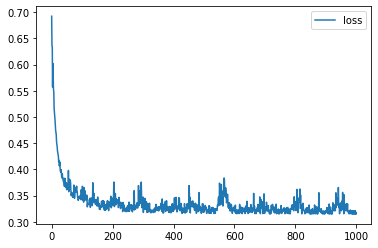

In [7]:
train_result = []
for loss in loss_list :
    train_result.append(loss.detach().to('cpu').numpy())
plt.plot(train_result,label = "loss")
plt.legend()
plt.show()

### 4.5 检测图片中人数及戴口罩的人数

In [8]:
img = Image.open("test.jpg")
detector = FaceDetector()
recognize = Recognition(model_path='temp.pth')
draw, all_num, mask_nums = recognize.mask_recognize(img)
plt.imshow(draw)
plt.show()
print("all_num:", all_num, "mask_num", mask_nums)

FileNotFoundError: [Errno 2] No such file or directory: 'test.jpg'